#### **Purpose:**
This cell imports the necessary libraries for network visualization and analysis. It defines the paths to the required datasets and sets up the configuration for the plots.

#### **Code Functionality:**
* Imports **pandas**, **numpy**, **networkx**, and **matplotlib**.
* Defines paths to the `final_prepared_data.csv` (for calculating correlations and getting recession dates) and `network_features.csv` (for the time-series plots).
* Defines a dictionary `critical_periods` for which network graphs will be generated.

#### **Output Analysis:**
This cell prints a confirmation message that the notebook has started and produces no other output.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

# --- Configuration ---
# Path for the original prepared data (for correlations and recession dates)
ORIGINAL_PREPARED_DATA_PATH = 'E:/Project_3/Recession_Prediction_Network_Analysis/data/final_prepared_data.csv'
# Path for the engineered network features
NETWORK_FEATURES_PATH = 'E:/Project_3/Recession_Prediction_Network_Analysis/data/network_features.csv'
# Output directory for visuals
VISUALIZATIONS_DIR = 'E:/Project_3/Recession_Prediction_Network_Analysis/visualizations/'
os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)


# Define Critical Periods for Network Graph Visualization
critical_periods = {
    'Stable Period (2015-mid)': '2015-06-30',
    'Pre-COVID Recession (2020-early)': '2020-01-31',
    'During COVID Recession (2020-mid)': '2020-04-30',
    'Recovery Period (2022-mid)': '2022-06-30',
}

print("✅ Starting Phase 5: Qualitative Network Visualization and Analysis.")

✅ Starting Phase 5: Qualitative Network Visualization and Analysis.


#### **Purpose:**
This cell defines a helper function to calculate a correlation matrix for a specific point in time and loads the required datasets.

#### **Code Functionality:**
* **`get_correlation_matrix_for_date`**: This function takes a date and a DataFrame, slices it to include data up to that date, takes the last 12 months, and returns the correlation matrix for that window.
* The code then loads both the original prepared data (for calculating correlations) and the network features data (for time-series plots). The 'Recession' column is also extracted for plotting.

#### **Output Analysis:**
The output confirms that all necessary data files have been loaded successfully and are ready for the visualization cells.

In [2]:
# --- Function to get correlation matrix for a given date ---
def get_correlation_matrix_for_date(date, X_data_for_correlation, window_size=12):
    if X_data_for_correlation.empty:
        return pd.DataFrame(index=[], columns=[])
    X_data_for_correlation = X_data_for_correlation.sort_index()
    data_up_to_date = X_data_for_correlation[X_data_for_correlation.index <= date]
    if len(data_up_to_date) < window_size:
        return pd.DataFrame(index=X_data_for_correlation.columns, columns=X_data_for_correlation.columns)
    else:
        corr_matrix = data_up_to_date.tail(window_size).corr()
    corr_matrix.fillna(0, inplace=True)
    return corr_matrix

# --- Load Data for Visualizations ---
try:
    df_original = pd.read_csv(ORIGINAL_PREPARED_DATA_PATH, index_col=0, parse_dates=True)
    X_for_corr = df_original.drop(columns=['Recession'])
    recession_dates = df_original['Recession']
    network_features_df = pd.read_csv(NETWORK_FEATURES_PATH, index_col='Date', parse_dates=True)
    print("✅ Successfully loaded all data required for visualization.")
except Exception as e:
    print(f"❌ An error occurred during data loading: {e}")

✅ Successfully loaded all data required for visualization.


#### **Purpose:**
This cell iterates through the defined critical periods, calculates the correlation network for each, and generates a visualization of the network structure, saving each as a PNG image.

#### **Code Functionality:**
* Loops through the `critical_periods` dictionary.
* Inside the loop, it calls the helper function to get the correlation matrix for each specific date.
* It creates a `networkx` graph where edges are defined by correlations exceeding a threshold of 0.5.
* Edge weights are converted to a non-negative `distance` metric (`1 - abs(correlation)`) for the layout algorithm.
* The `nx.kamada_kawai_layout` function is used to position the nodes aesthetically.
* `matplotlib` is used to draw the nodes, edges, and labels, and the final graph is saved to the `/visualizations` directory.

#### **Output Analysis:**
For each period, the cell prints a status message confirming that the network is being visualized and then a success message once the corresponding image file has been saved.

In [3]:
# --- Step 5.1: Visualizing Network Dynamics at Critical Periods ---
print("--- Step 5.1: Visualizing Network Dynamics at Critical Periods ---")

for period_name, date_str in critical_periods.items():
    date = pd.to_datetime(date_str)
    print(f"\nVisualizing network for: {period_name} ({date.strftime('%Y-%m')})")
    
    corr_matrix = get_correlation_matrix_for_date(date, X_for_corr)

    if corr_matrix.empty:
        print(f"Skipping {period_name}: Insufficient data.")
        continue

    G = nx.Graph()
    for col in corr_matrix.columns: G.add_node(col)

    threshold = 0.5
    edges_to_add = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            node1, node2 = corr_matrix.columns[i], corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]
            if pd.notna(correlation) and abs(correlation) > threshold:
                edges_to_add.append((node1, node2, {'weight': 1 - abs(correlation), 'strength': abs(correlation), 'sign': np.sign(correlation)}))
    
    G.add_edges_from(edges_to_add)
    G.remove_nodes_from(list(nx.isolates(G)))

    if G.number_of_nodes() == 0:
        print(f"No nodes left in graph for {period_name}. Skipping plot.")
        continue

    plt.figure(figsize=(14, 11))
    pos = nx.kamada_kawai_layout(G)
    node_sizes = [G.degree(n) * 100 + 50 for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_sizes, alpha=0.9)
    
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sign'] > 0]
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sign'] < 0]
    edge_widths = [d['strength'] * 2.5 for u, v, d in G.edges(data=True)]

    nx.draw_networkx_edges(G, pos, edgelist=positive_edges, edge_color='green', width=edge_widths, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=negative_edges, edge_color='red', width=edge_widths, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')

    plt.title(f'Economic Network: {period_name} ({date.strftime("%Y-%m")})', size=16)
    plt.axis('off')
    
    file_path = os.path.join(VISUALIZATIONS_DIR, f'network_dynamic_{period_name.replace(" ", "_").replace("(", "").replace(")", "").lower()}.png')
    plt.savefig(file_path, dpi=200)
    plt.close()
    
    print(f"✅ Network visualization for {period_name} saved.")

print("\n" + "-" * 60)

--- Step 5.1: Visualizing Network Dynamics at Critical Periods ---

Visualizing network for: Stable Period (2015-mid) (2015-06)
✅ Network visualization for Stable Period (2015-mid) saved.

Visualizing network for: Pre-COVID Recession (2020-early) (2020-01)
✅ Network visualization for Pre-COVID Recession (2020-early) saved.

Visualizing network for: During COVID Recession (2020-mid) (2020-04)
✅ Network visualization for During COVID Recession (2020-mid) saved.

Visualizing network for: Recovery Period (2022-mid) (2022-06)
✅ Network visualization for Recovery Period (2022-mid) saved.

------------------------------------------------------------


#### **Purpose:**
This cell generates the missing time-series visualizations. It plots the evolution of a few key network centrality features over the entire historical period, with actual recessions shaded in the background for context.

#### **Code Functionality:**
* Defines a list, `features_to_plot`, containing the names of a few key centrality features to analyze.
* Loops through this list.
* For each feature, it creates a plot showing the feature's value over time.
* It then overlays gray vertical bars (`axvspan`) on the plot to indicate the historical periods of NBER-defined recessions.
* Each plot is saved as a separate PNG file.

#### **Output Analysis:**
The output confirms that a time-series plot has been generated and saved for each of the specified centrality features. These plots allow for a direct visual analysis of how network properties change during economic downturns.

--- Step 5.2: Visualizing Time Series of Centrality Features ---


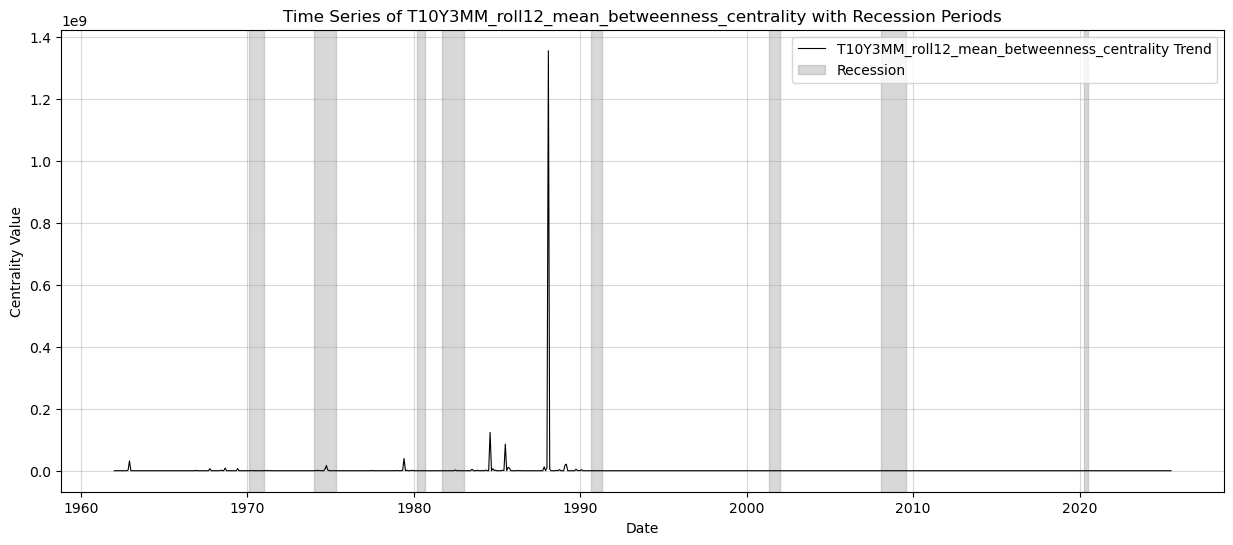

✅ Time series plot for T10Y3MM_roll12_mean_betweenness_centrality saved.


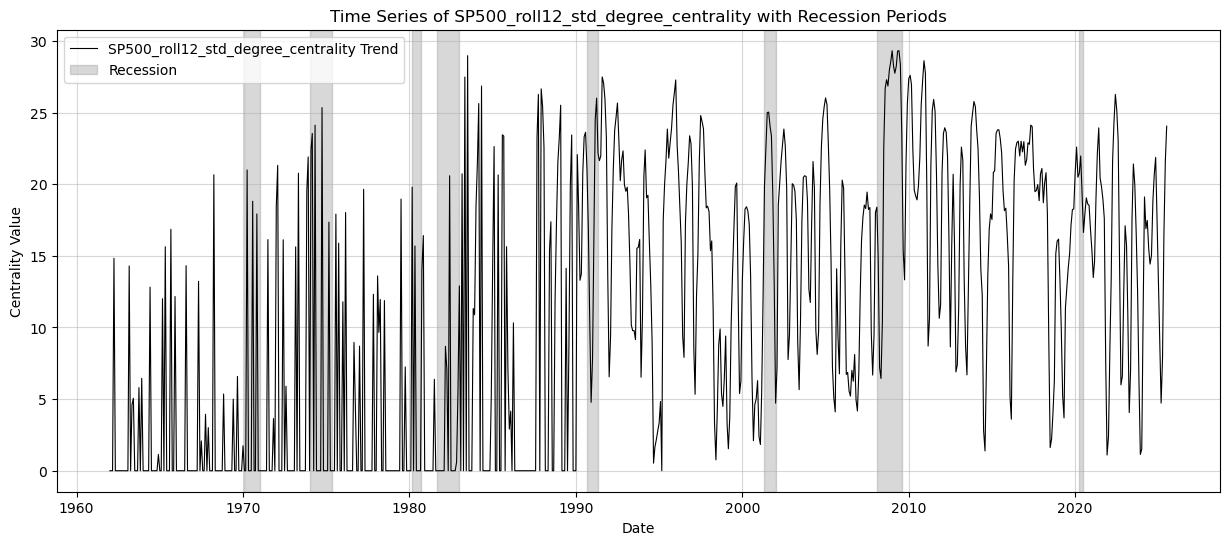

✅ Time series plot for SP500_roll12_std_degree_centrality saved.


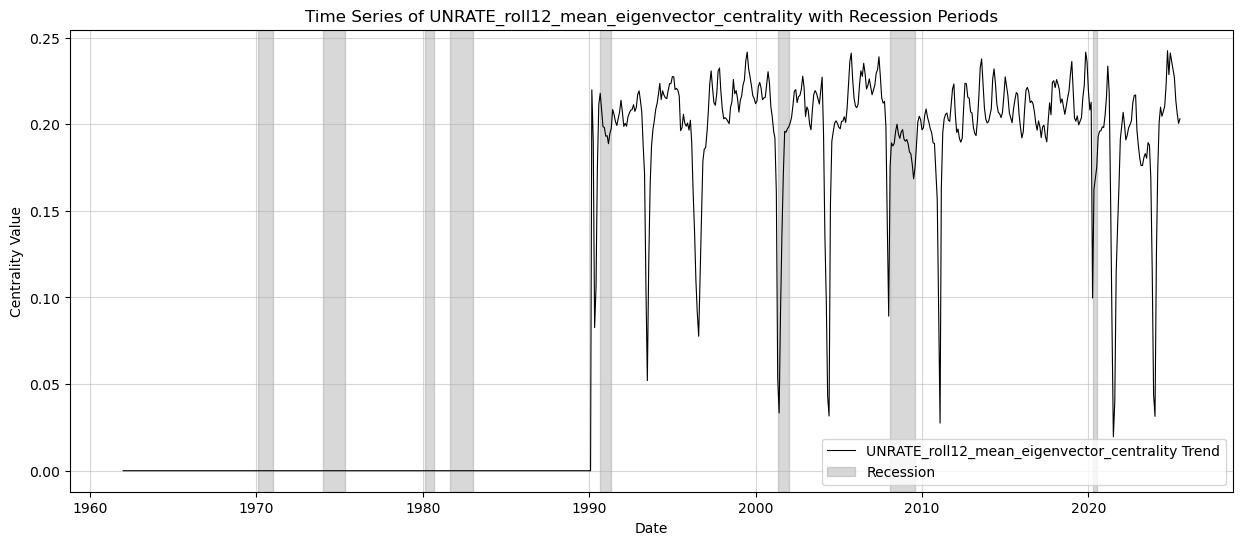

✅ Time series plot for UNRATE_roll12_mean_eigenvector_centrality saved.

------------------------------------------------------------


In [4]:
# --- Step 5.2: Visualize Time Series of Centrality Features ---
print("--- Step 5.2: Visualizing Time Series of Centrality Features ---")

# Select a few key features to visualize over time
features_to_plot = [
    'T10Y3MM_roll12_mean_betweenness_centrality',
    'SP500_roll12_std_degree_centrality',
    'UNRATE_roll12_mean_eigenvector_centrality'
]

# Align recession dates with the network features index
recession_data_aligned = recession_dates.reindex(network_features_df.index).fillna(0)

for feature in features_to_plot:
    if feature in network_features_df.columns:
        plt.figure(figsize=(15, 6))
        
        # Plot the centrality feature
        plt.plot(network_features_df.index, network_features_df[feature], label=f'{feature} Trend', color='black', lw=0.8)
        
        # Shade recession periods
        start_date = None
        for date, is_recession in recession_data_aligned.items():
            if is_recession == 1 and start_date is None:
                start_date = date
            elif is_recession == 0 and start_date is not None:
                plt.axvspan(start_date, date, color='gray', alpha=0.3, label='Recession' if start_date == recession_data_aligned[recession_data_aligned==1].index[0] else "")
                start_date = None
        if start_date is not None:
             plt.axvspan(start_date, recession_data_aligned.index[-1], color='gray', alpha=0.3)


        plt.title(f'Time Series of {feature} with Recession Periods')
        plt.xlabel('Date')
        plt.ylabel('Centrality Value')
        plt.legend()
        plt.grid(True, alpha=0.5)
        
        file_path = os.path.join(VISUALIZATIONS_DIR, f'timeseries_{feature}.png')
        plt.savefig(file_path, dpi=200)
        plt.show()
        print(f"✅ Time series plot for {feature} saved.")
    else:
        print(f"⚠️ Warning: Feature '{feature}' not found in network_features_df.")

print("\n" + "-" * 60)